# Searching for a Needle in a "Signal Haystack"

In [16]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

file_exists = exists('hidden_omega0.py')
if (not file_exists):
    !wget -O hidden_omega0.py https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/hidden_omega0.py

import os
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data

if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.8.17
Running Sympy: 1.12rc1


## Discussion:
* Consider case of a received signal that is weak (low amplitude) and there is lots of noise.

* All we know is that it is a sinusoidal signal and we have rough idea of the signal frequency

In [17]:
dt = 0.001 # emaulate measuring a cts signal by having dt very small compared to freq of signal
tf = 60 # sec of data
t = np.arange(0,tf,dt)

In [18]:
# Truth variables (i.e. not known to us)
omega_lower_bound = 10
omega_upper_bound = 20
runfile('hidden_omega0.py') # returns omega0, f0, T0, and phi_true

In [19]:
# Measured
omega =  2*np.pi # a (bad) guess
y_true = np.sin(omega0 * t + phi_true) 
y = y_true + 20*np.random.randn(np.size(t))  # add some noise
# Faked as if I knew omega but not phi
y_faked = np.sin(omega0 * t) 

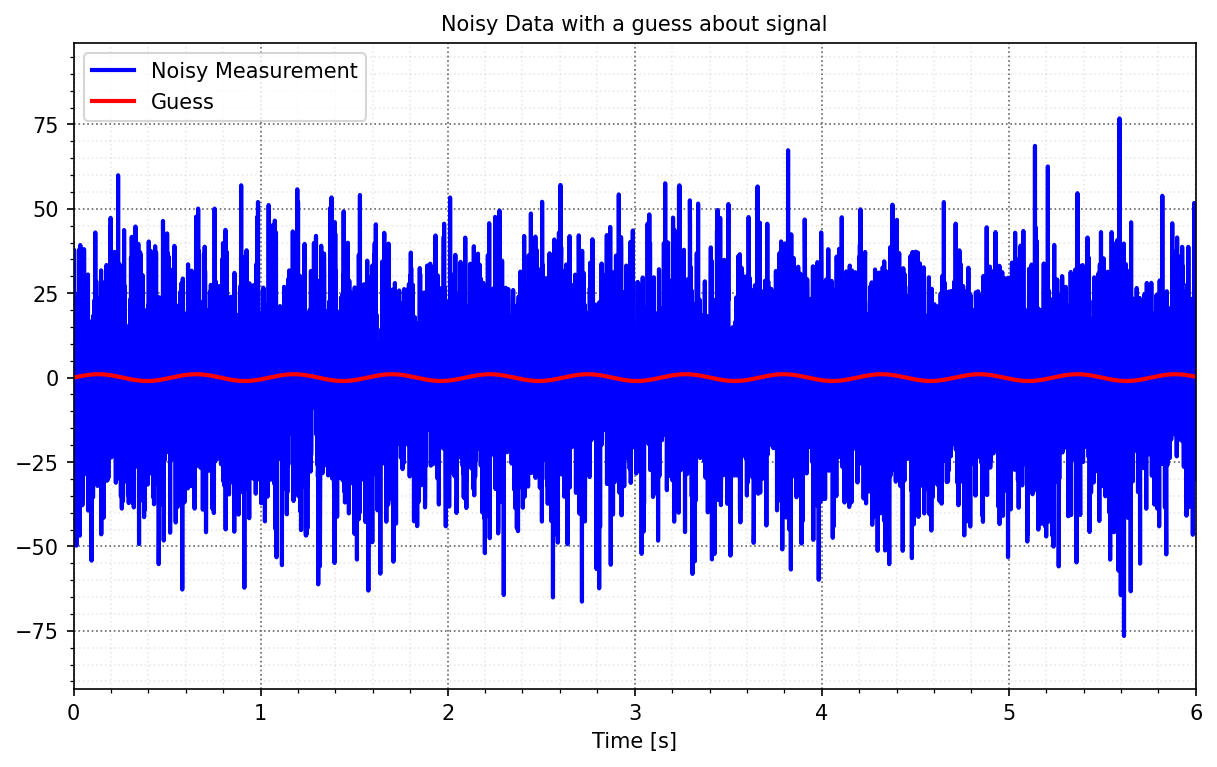

In [20]:
fig = plt.figure(figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t,y,'b-',label='Noisy Measurement')
plt.plot(t,y_faked,'red',label='Guess')
plt.legend()
plt.xlim(0,tf/10)
plt.xlabel("Time [s]")
plt.title('Noisy Data with a guess about signal')
nicegrid()
plt.show()
fig.savefig('./figs/Correlation1.png', dpi=300)

## Pattern Matching
* Even if we knew the freqeuncy of the signal (orange line) - we don't known the phase offset ($\phi$)
* That offset depends on clock offsets in systems that are hard to keep synchronized in distributed systems (think satellites)

* Thus we have to do pattern matching - we basically create a replica signal as 
above, and then choose a range of $0\leq\phi\leq 2\pi$ to see if any match better than others

* Matching deptermined by computing the *correlation*
$$ C[j] =\sum_i y_{meas}[i] y_{replica}[i,j]$$
where $i$ is the index over mesurements taken and $j$ determines what value of $\phi$ is being used

* Must pay attention to the end points of the replica signal (use np.roll).

* We don't know the right amplitude to use either, but that is a scaling error in all $C[j]$ values - so can just look for the largest value across all computed.

In [6]:
#Must determine how data points we are going to sweep over phi - nominally depends on frequency guess
N0 = 2*int(T0/dt) # number of samples per period 

# Implement the correlation process between 2 signals - sweep overal all possible offsets in 1 loop
def my_correlate(A,B,N = N0):
    C = np.zeros([N,1]) # confirm which N is being used
    for ii in np.arange(0,N):
        C[ii] = np.correlate(A, np.roll(B,ii))
    return C

In [7]:
def func(phi_test = 0):
    fig = plt.figure(figsize=(8, 5),dpi=150,constrained_layout = True)
    y_test = 0.2*np.sin(omega0 * t + phi_test)  # another measured one (diff amplitude)
    plt.plot(t,y_true,'b-',label='Truth') # true signal from above (no noise)
    plt.plot(t,y_test,'r--',label='Guess')
    plt.xlim(0,3)
    plt.xlabel('Time [s]')
    plt.legend()
    nicegrid()
    plt.title(f'Correlation for $\phi = $ {phi_test:.2f} is {np.correlate(y_true,y_test)[0]:.2f}')
    plt.text(0.25,-1,f'Actual $\phi = $ {phi_true[0]:.2f}') #   
    plt.show()

yout = interactive(func,phi_test=(-np.pi,np.pi,0.05))
yout

interactive(children=(FloatSlider(value=0.0, description='phi_test', max=3.141592653589793, min=-3.14159265358…

## Now back to analyzing the meaured data

In [8]:
z = my_correlate(y_faked,y_true)

# Look for largest value of the 
phi_corr = 2 * (2 * np.pi) * (np.argmax(z)/N0) # 4pi bec N0 is for 2 periods
PHI = np.arange(0,N0)*4*np.pi/N0 # 4pi bec N0 is for 2 periods

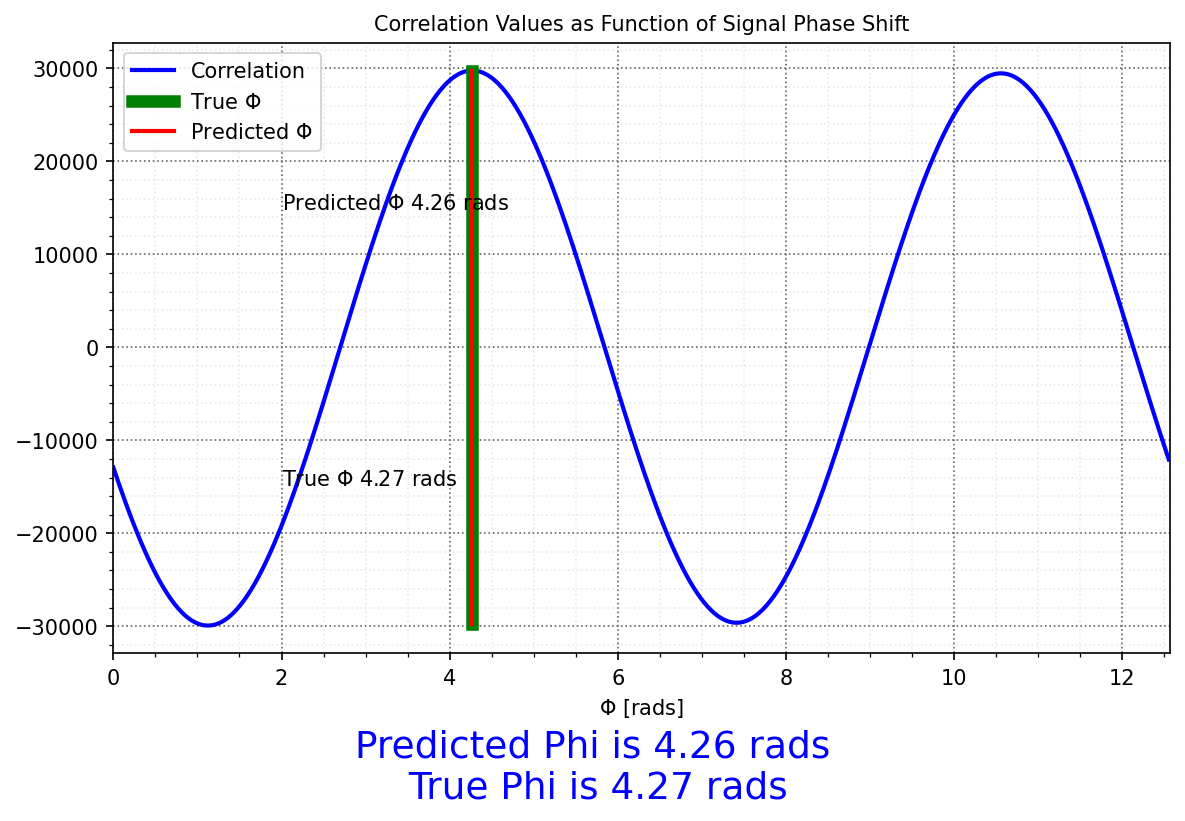

In [9]:
fig = plt.figure(figsize=(8, 5))
plt.plot(PHI,z,'b-',label='Correlation')
plt.plot([phi_true,phi_true],[max(z),-max(z)],'g-',lw=6,label='True $\Phi$')
plt.plot([phi_corr,phi_corr],[max(z),-max(z)],'r-',lw=2,label='Predicted $\Phi$')
plt.text(2, max(z)/2, f'Predicted $\Phi$ {phi_corr:.2f} rads')
plt.text(2, -max(z)/2, f'True $\Phi$ {phi_true[0]:.2f} rads')
nicegrid()
plt.xlabel('$\Phi$ [rads]')
plt.xlim(0,4*np.pi)
plt.legend()
plt.title("Correlation Values as Function of Signal Phase Shift")

caption(f'Predicted Phi is {phi_corr:.2f} rads\n True Phi is {phi_true[0]:.2f} rads',fig,yloc=-0.075)
plt.show()


## Now on to the hard case - what if we don't know $\omega$ very well
* Thoughts on why that might happen?

In [10]:
# Set up a range of possible Omega values 
# Recall truth is Omega0
# Create a range of Nw values of possible Omegas about the true Omega0
Nw = 20
Wrange = omega_upper_bound - omega_lower_bound
d_omega = Wrange/(2*Nw);
omega_range = np.arange(omega_lower_bound,omega_upper_bound,d_omega)
# index of right answer
N_omega0 = min(int((omega0-omega_lower_bound)/d_omega),len(omega_range)-1)

CC = np.zeros([2*Nw,N0])
for ii in np.arange(2*Nw):
    y_test = np.sin((omega_range[ii]) * t) # new test freq
    CC[ii,:] = my_correlate(y_test,y).T # this sweep over all phase offsets 

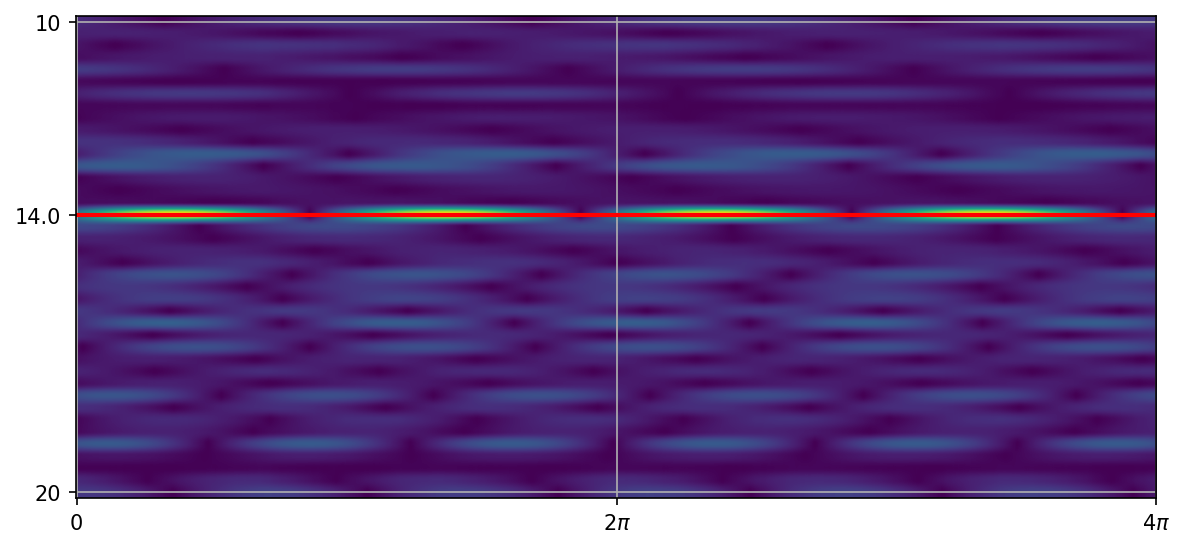

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(np.abs(CC),aspect=10)
plt.plot([0,N0-1],[N_omega0,N_omega0],'r')
plt.yticks([0,N_omega0,2*Nw-1],[f'{omega_range[0]:.0f}',str(round(omega_range[N_omega0],1)),f'{omega_range[2*Nw-1]:.0f}'])
plt.xticks([0,int(N0/2),N0-1],[0,'$2\pi$','$4\pi$'])
plt.show()
fig.savefig('./figs/Correlation3.png', dpi=300)

In [12]:
# Look for best correlation across all freq and phi sweeps
ind = np.unravel_index(np.argmax(CC, axis=None), CC.shape)
omega_pred = omega_lower_bound + d_omega*ind[0]

In [13]:
f_pred = omega_pred/(2*np.pi) # Hz
T_pred = 1/f_pred  # period in secs
N_pred = int(T_pred/dt) # number of samples per period
phi_pred = ind[1]/N_pred * 2 * np.pi
print(f'\tTrue Omega {omega0:.1f} rad/s')
print(f'\tPred Omega {omega_pred:.1f} rad/s\n')
print(f'\tTrue Phi {phi_true[0]:.1f} rad')
print(f'\tPred Phi {phi_pred:.1f} rad')

	True Omega 14.0 rad/s
	Pred Omega 14.0 rad/s

	True Phi 4.3 rad
	Pred Phi 4.3 rad


## Alternate Approach

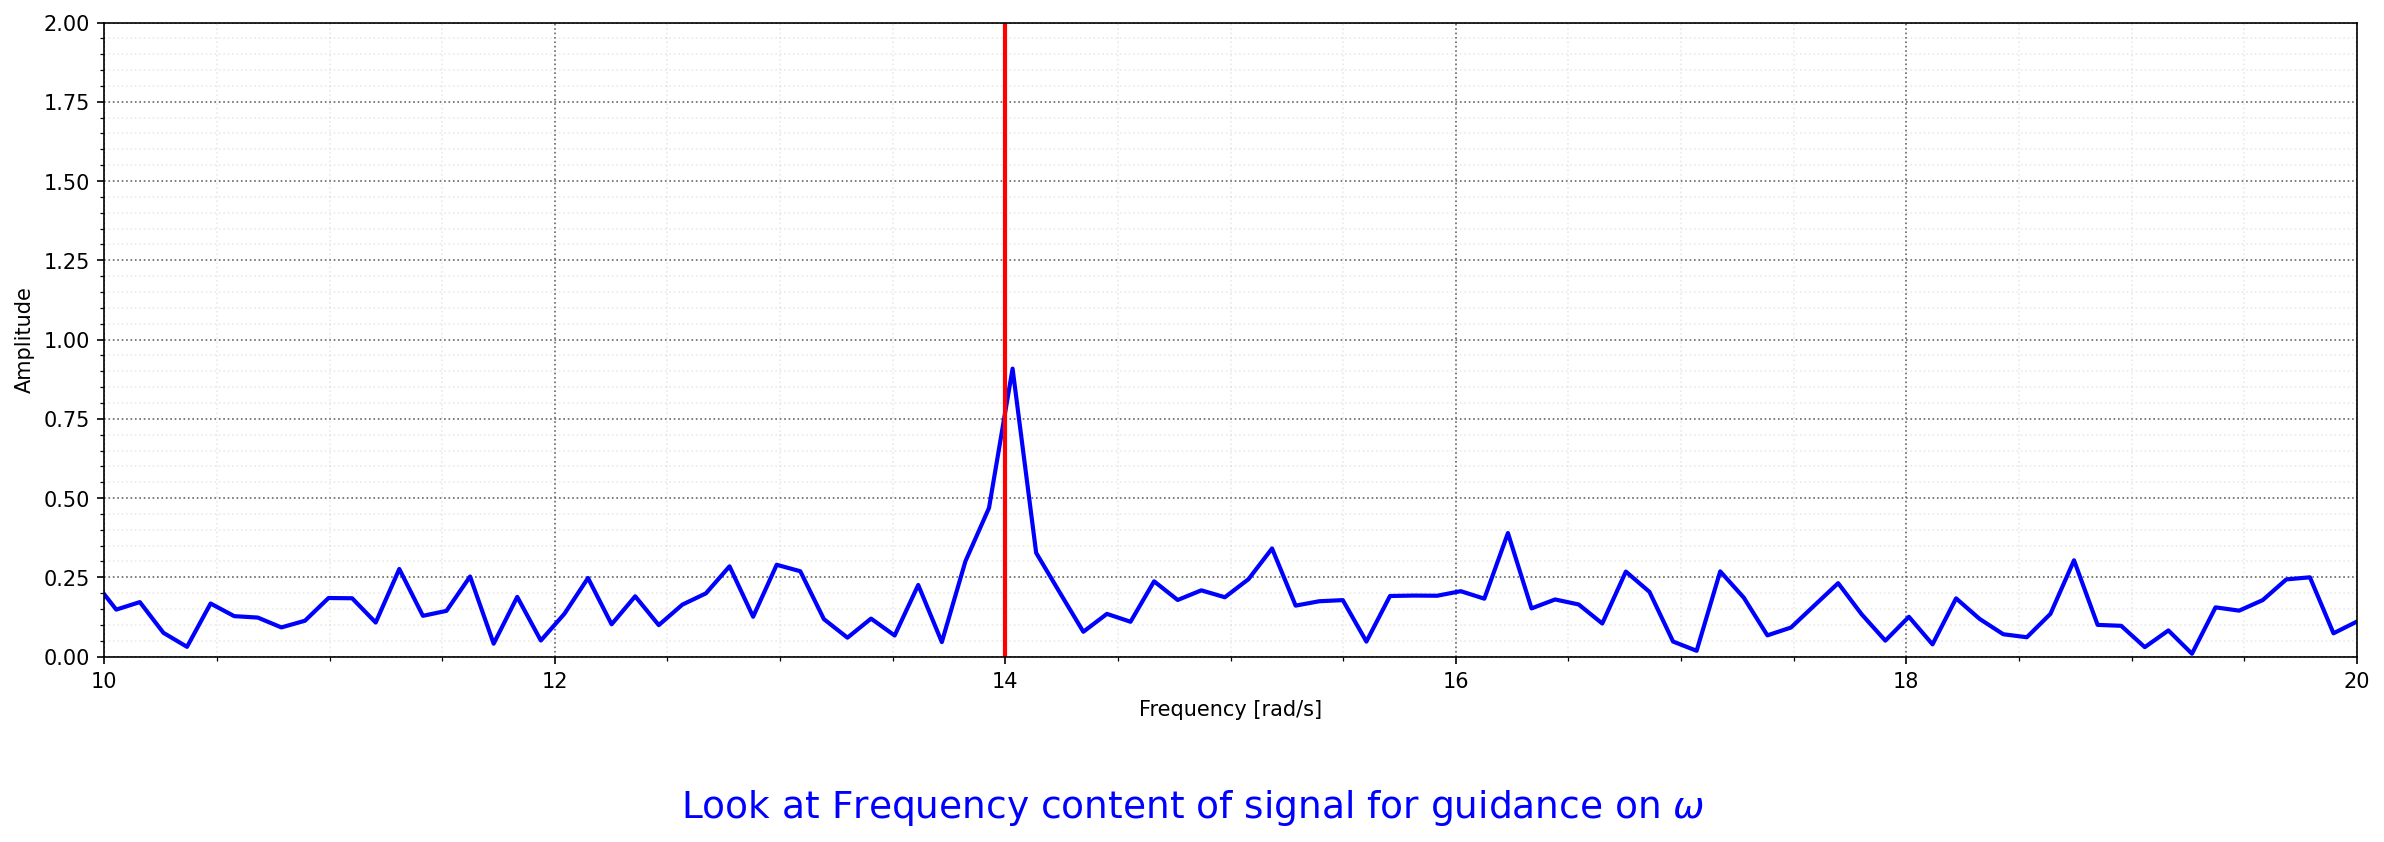

In [14]:
# Alternate way to estimate Omega given the measured data - look for the peak in the FFT plot
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
Nfft = len(t)

fig = plt.figure(figsize=(16, 5))
yf = fft(y)
ff = fftfreq(Nfft, dt)[1:Nfft//2]*2*np.pi
plt.plot(ff, 2.0/Nfft * np.abs(yf[1:Nfft//2]),'b-')
plt.plot([omega0, omega0], [0,2],'r-')

plt.ylabel('Amplitude')
plt.xlabel('Frequency [rad/s]')
plt.xlim([omega_lower_bound, omega_upper_bound])
plt.ylim([0, 2])
caption("Look at Frequency content of signal for guidance on $\omega$",fig)
nicegrid()
plt.show()